In [ ]:
m_name = 'bbc_2_nofre' # 保存model名称
dsid = 3 # 选择不同的数据集进行训练 ['/bq_corpus','/lcqmc','/paws-x-zh']，千言文本相似度比赛三个数据集是分开记分的

In [10]:
debug = 1
seed = 218

# Model hyperparameter
device = 'cuda'
bert_model = 'bert-base-chinese' # 'hfl/chinese-roberta-wwm-ext'
freeze_bert = False
maxlen = 128
finetune_units = 1024
dropout_rate = 0.1

#　Train Hyperparameter
bs = 16
lr = 2e-5  
if debug:
    epochs = 4
    num_warmup_steps = 0
else:
    epochs = 8
    num_warmup_steps = 2

# Postprocess hyperparameter
thres = 0.5

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.8MB/s 
     |████████████████████████████████| 890kB 38.6MB/s 
     |████████████████████████████████| 3.2MB 40.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f6e6406ad531c61c20106fdd0f78cb6762b15820e36ec7c6ef99b99c24e85246
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [13]:
from scipy.spatial import distance
from scipy.spatial.distance import cosine
import nltk
from scipy.stats import pearsonr

import sys
import os
import numpy as np 
import pandas as pd
import copy
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn
import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

#float16和float32自动混合精度加速计算，官方文档：https://pytorch.org/docs/stable/amp.html
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [14]:
def set_seed(seed = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    return seed

seed = set_seed(seed)

In [ ]:
# PATH Info
CURR_PATH = os.getcwd()
ROOT_PATH = CURR_PATH + '/drive/MyDrive/Baidu_Qianyan'

In [ ]:
def read_tsv(input_file):
    with open(input_file,"r",encoding="utf-8") as file:
        lines = []
        for line in file:
            if len(line.strip().split("\t")) != 1:
                lines.append(line.strip().split("\t"))
        df = pd.DataFrame(lines)
    return df

DATASET_PATH = ['/bq_corpus','/lcqmc','/paws-x-zh']
dataset_path = DATASET_PATH[dsid]
ROOT_PATH = '/content/drive/MyDrive/Baidu_Qianyan'
DATA_PATH = ['/train.tsv','/dev.tsv','/test.tsv']
MODEL_SAVE_PATH = ROOT_PATH + '/model' + DATASET_PATH[0] + '/' + m_name + '/'

train = pd.DataFrame()
dev = pd.DataFrame()
test = pd.DataFrame()
for dataset_path in DATASET_PATH:
    PATH = ''.join([ROOT_PATH,dataset_path])
    PATH = ''.join([PATH,data_path])
    df = read_tsv(PATH)
    if data_path == '/train.tsv':
        train = pd.concat([train,df],axis = 0)
    if data_path == '/dev.tsv':
        dev = pd.concat([dev,df],axis = 0)
    if data_path == '/test.tsv':
        test = pd.concat([test,df],axis = 0)

## bq_corpus在20746行的格式有问题，以下方法无法读取
# train = pd.DataFrame()
# for dataset_path in DATASET_PATH:
#     print(dataset_path)
#     for data_path in DATA_PATH:
#         PATH = ''.join([ROOT_PATH,dataset_path])
#         PATH = ''.join([PATH,data_path])
#         read_df = pd.read_csv(PATH, header=0, delimiter='\t')
#         train.append(read_df)



train[[2]] = train[[2]].astype(int)
dev[[2]] = dev[[2]].astype(int)

In [ ]:
train.describe()

,2
count,49129.000000
mean,0.441369
std,0.496556
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49129 entries, 0 to 49128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       49129 non-null  object
 1   1       49129 non-null  object
 2   2       49129 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
cols_dict=['sentence_a', 'sentence_b', 'similarity']
train.columns = cols_dict
dev.columns = cols_dict
test.columns = cols_dict[:2]

In [ ]:
train.head()

,sentence_a,sentence_b,similarity
0,1560年10月，他在巴黎秘密会见了英国大使Nicolas Throckmorton，要求他...,1560年10月，他在巴黎秘密会见了英国大使尼古拉斯·斯罗克莫顿，并要求他通过英格兰返回苏格...,0
1,1975年的NBA赛季 - 76赛季是全美篮球协会的第30个赛季。,1975-76赛季的全国篮球协会是NBA的第30个赛季。,1
2,还有具体的讨论，公众形象辩论和项目讨论。,还有公开讨论，特定档案讨论和项目讨论。,0
3,当可以保持相当的流速时，结果很高。,当可以保持可比较的流速时，结果很高。,1
4,它是Akmola地区Zerendi区的所在地。,它是Akmola地区Zerendi区的所在地。,1


In [ ]:
if debug:
    df_train = train.iloc[2000:20000,:].reset_index(drop = True)
    df_val = train.iloc[:2000,:]
else:
    df_train = train
    df_val = dev
df_val

,sentence_a,sentence_b,similarity
0,1560年10月，他在巴黎秘密会见了英国大使Nicolas Throckmorton，要求他...,1560年10月，他在巴黎秘密会见了英国大使尼古拉斯·斯罗克莫顿，并要求他通过英格兰返回苏格...,0
1,1975年的NBA赛季 - 76赛季是全美篮球协会的第30个赛季。,1975-76赛季的全国篮球协会是NBA的第30个赛季。,1
2,还有具体的讨论，公众形象辩论和项目讨论。,还有公开讨论，特定档案讨论和项目讨论。,0
3,当可以保持相当的流速时，结果很高。,当可以保持可比较的流速时，结果很高。,1
4,它是Akmola地区Zerendi区的所在地。,它是Akmola地区Zerendi区的所在地。,1
...,...,...,...
1995,2012年7月26日，谷开来被控谋杀Neil Heywood。,2012年7月26日，Neil Heywood被指控谋杀了谷开来。,0
1996,Kirk Deighton从780号公路，Knaresborough到Wetherby，以及...,Kirk Deighton的路线为780，Harrogate为Wetherby，路线为X70...,0
1997,1958年，他在整个东亚和西欧，以及1961年在加纳北部讲话。,1958年，他于1961年在整个东亚和加纳，北欧和西欧讲话。,0
1998,他出生于纽约西点，并在犹他州的韦伯州立大学就读。,Liparulo出生于犹他州西点。他曾就读于纽约的韦伯州立大学。,0


In [ ]:
df_train

,sentence_a,sentence_b,similarity
0,改变所选择的测定，改变细胞上的选择压力，因此可以改变转化细胞中使用的性质。,如果所选择的测定法变化，则选择性压力在细胞上改变，因此可以改变转化细胞中使用的特性。,1
1,办公室搬到德里米尔斯并于1871年2月重新建立，尽管Scio办公室于1871年9月更名。,办公室搬到了德里米尔斯，并于1871年2月重新命名，尽管Scio办公室于1871年9月重建。,0
2,1844年，布鲁克林从波士顿吞并成为Pill Hill的一部分。,Pill Hill于1844年成为Brookline的一部分，当时它被波士顿吞并。,0
3,它们构成了西河的大部分人口和里奥内格罗河口上方的沃佩斯河上游。,它们构成了Xié河和Vaupés河口上方Rio Negro上游的大部分人口。,0
4,可以反转倾斜传感器，以便能够在GBA SP上正确播放。,可以播放倾斜传感器，以便能够在GBA SP上正确地反转它。,0
...,...,...,...
17995,它于2007年5月8日由Blu授权并在台湾出版。该漫画由Sharp Point Press在...,它于2007年5月8日由Blu在北美授权并在北美出版，并由台湾的Sharp Point Pr...,0
17996,Ellerslie火车站为奥克兰的新西兰铁路网南线和Onehunga线提供服务，拥有岛屿平台。,Ellerslie火车站为奥克兰的新西兰铁路网南线和Onehunga线提供服务。它有一个岛屿平台。,1
17997,Grevillea macleayana，俗称新南威尔士grevillea，是一种原产于杰维...,Grevillea macleayana，俗称新南威尔士grevillea，是一种原产于杰维...,1
17998,如今，盖尔斯堡 - 奥古斯塔社区学校由奥古斯塔的一所中学和一所高中以及盖尔斯堡的一所小学组成。,今天，Galesburg-Augusta由来自小学的社区学校和Galesburg的一所高中以...,0


In [ ]:
class LoadDataset(Dataset):
    def __init__(self, data, maxlen, with_labels=True, bert_model='bert-base-chinese'):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained(bert_model,output_loading_info = False)  
        self.maxlen = maxlen
        self.with_labels = with_labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = str(self.data.loc[index,'sentence_a'])
        sent2 = str(self.data.loc[index,'sentence_b'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_input1 = self.tokenizer(sent1, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        encoded_input2 = self.tokenizer(sent2, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        token_ids1 =  encoded_input1['input_ids'].squeeze(0) 
        attn_masks1 =  encoded_input1['attention_mask'].squeeze(0)  
        token_type_ids1 =  encoded_input1['token_type_ids'].squeeze(0) 

        token_ids2 =  encoded_input2['input_ids'].squeeze(0)  
        attn_masks2 =  encoded_input2['attention_mask'].squeeze(0) 
        token_type_ids2 =  encoded_input2['token_type_ids'].squeeze(0) 
        
        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'similarity']
            return token_ids1, attn_masks1, token_type_ids1, token_ids2, attn_masks2, token_type_ids2, label  
        else:
            return token_ids1, attn_masks1, token_type_ids1, token_ids2, attn_masks2, token_type_ids2

In [ ]:
def val_lossF(net, device, criterion, dataloader):
    net.eval()
    mean_loss = 0
    count = 0
    true_labelss = []
    list_val_outputs = []
    val_metric = 0
    
    with torch.no_grad():
        for  i, (token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2,labels) in enumerate(dataloader):
            token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
            token_ids2, attn_masks2, token_type_ids2 = token_ids2.to(device), attn_masks2.to(device), token_type_ids2.to(device)
            labels = labels.to(device)
            
            val_output = net(token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2)
            mean_loss += criterion(val_output, labels.float()).item()
            count += 1

            val_outputs = val_output.sigmoid().cpu().numpy()
            val_outputs = np.where(val_outputs>thres, 1, 0)
            list_val_outputs += val_outputs.tolist()
            labelss = labels.cpu().numpy()
            true_labelss += labelss.tolist()  

        val_metric = accuracy_score(list_val_outputs,true_labelss)       
    return mean_loss / count, val_metric

In [ ]:
class TextSimilarityModel(nn.Module):
    def __init__(self, dropout_rate=0.2, finetune_units=768, bert_model='bert-base-chinese', freeze_bert=False):
        super(TextSimilarityModel, self).__init__()
        self.bert_layer = BertModel.from_pretrained(bert_model,output_loading_info = False)
        
        if bert_model == 'bert-base-chinese':
            self.hidden_size = 768
        elif bert_model == 'hfl/chinese-roberta-wwm-ext':
            self.hidden_size = 768
            
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        self.dropout0 = nn.Dropout(p=dropout_rate)
        self.linear1 = nn.Linear(self.hidden_size, finetune_units)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.linear2 = nn.Linear(finetune_units, finetune_units)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.vec_layer = nn.Linear(finetune_units,self.hidden_size)
        
        self.cs_layer = nn.CosineSimilarity(dim=1)
        
    def mean_pooling(self,all_vecs, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(all_vecs.size()).float()
        sum_embeddings = torch.sum(all_vecs * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    @autocast()
    def forward(self,  token_ids1, attn_masks1, token_type_ids1, token_ids2, attn_masks2, token_type_ids2):
        # all_vecs1, cls_vecs1 = self.bert_layer(token_ids1, attn_masks1, token_type_ids1)
        # all_vecs2, cls_vecs2 = self.bert_layer(token_ids2, attn_masks2, token_type_ids2)
        vecs1 = self.bert_layer(token_ids1, attn_masks1, token_type_ids1)
        vecs2 = self.bert_layer(token_ids2, attn_masks2, token_type_ids2)        

        #Perform pooling. In this case, mean pooling
        sent_embed1 = self.mean_pooling(vecs1[0], attn_masks1)
        sent_embed2 = self.mean_pooling(vecs2[0], attn_masks2)

        # vec1
        x1 = self.dropout0(sent_embed1)
        x1 = self.relu1(self.linear1(x1))
        x1 = self.dropout1(x1)
        x1 = self.relu2(self.linear2(x1))
        x1 = self.dropout2(x1)
        x1 = self.vec_layer(x1)
        
        # vec2
        x2 = self.dropout0(sent_embed2)
        x2 = self.relu1(self.linear1(x2))
        x2 = self.dropout1(x2)
        x2 = self.relu2(self.linear2(x2))
        x2 = self.dropout2(x2)
        x2 = self.vec_layer(x2)
    
        output = self.cs_layer(x1,x2)

        return output

In [ ]:
device = torch.device(device if torch.cuda.is_available() else "cpu")
net = TextSimilarityModel(dropout_rate=dropout_rate, finetune_units=finetune_units,bert_model=bert_model,freeze_bert=freeze_bert)
net.to(device)

TextSimilarityModel(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
train_set = LoadDataset(df_train, maxlen, bert_model)
val_set = LoadDataset(df_val, maxlen, bert_model)
train_loader = DataLoader(train_set, batch_size=bs)
val_loader = DataLoader(val_set, batch_size=bs)

criterion = nn.BCEWithLogitsLoss()
opti = AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
num_training_steps = epochs * len(train_loader)  # The total number of training steps
lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps )
scaler = GradScaler()

best_loss = np.Inf
best_ep = 1
iters = []
train_losses = []
val_losses = []
val_metrics = []
es_count = 0
for ep in range(epochs):
    net.train()
    for it, (token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2, labels) in tqdm(enumerate(train_loader),total = len(train_loader)):
        token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
        token_ids2, attn_masks2, token_type_ids2 = token_ids2.to(device), attn_masks2.to(device), token_type_ids2.to(device)
        labels = labels.to(device)
        opti.zero_grad()
        with autocast():
#             ot1,ot2 = net(token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2)
#             cs=nn.CosineSimilarity()
#             #output =  1.- cs(ot1,ot2)
#             output = cs(ot1,ot2)
            output = net(token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2)
            
            loss = criterion(output, labels.float())
        scaler.scale(loss).backward()
        scaler.step(opti)
        scaler.update()      
        lr_scheduler.step()

        # if it % 50 == 0:
        #     #print('debug stop')
        #     val_loss, val_metric = val_lossF(net, device, criterion, val_loader)  # Compute validation loss
        #     print("it = {}, train_loss = {}, val_loss = {}, val_metric= {}".format(it+1,loss,val_loss,val_metric))
            
    val_loss, val_metric = val_lossF(net, device, criterion, val_loader)  # Compute validation loss  
    print("Epoch {} complete! Train Loss : {} , Validation Loss : {} , Validation Metric - Accuracy : {} ".format(ep+1, loss, val_loss, val_metric))
    train_losses.append(loss)
    val_losses.append(val_loss)  
    val_metrics.append(val_metric)
    if val_loss < best_loss:       
        print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
        net_copy = copy.deepcopy(net)  # save a copy of the model
        best_loss = val_loss
        best_ep = ep + 1
        path_to_model='{}_ep_{}_val_loss_{}.pt'.format(m_name, best_ep, round(best_loss, 5))
        torch.save(net_copy.state_dict(), MODEL_SAVE_PATH + path_to_model)
        print("The model has been saved in {}".format(path_to_model))
    # else:
    #     es_count += 1
    
    # if early_stop and es_count>es_counts_MAX:
    #     print('Early Stop Train in Epoch : {} '.format(ep+1))
    #     break

del loss
torch.cuda.empty_cache()

100%|██████████| 1125/1125 [05:17<00:00,  3.54it/s]


Epoch 1 complete! Train Loss : 0.7070322632789612 , Validation Loss : 0.8714851622581482 , Validation Metric - Accuracy : 0.4395 
Best validation loss improved from inf to 0.8714851622581482


  0%|          | 0/1125 [00:00<?, ?it/s]

The model has been saved in bbc_2_nofre_ep_1_val_loss_0.87149.pt


100%|██████████| 1125/1125 [05:18<00:00,  3.54it/s]


Epoch 2 complete! Train Loss : 0.7141696214675903 , Validation Loss : 0.8659525094032288 , Validation Metric - Accuracy : 0.44 
Best validation loss improved from 0.8714851622581482 to 0.8659525094032288


  0%|          | 0/1125 [00:00<?, ?it/s]

The model has been saved in bbc_2_nofre_ep_2_val_loss_0.86595.pt


  0%|          | 0/1125 [00:00<?, ?it/s]

Epoch 3 complete! Train Loss : 0.6895807981491089 , Validation Loss : 0.8687757544517517 , Validation Metric - Accuracy : 0.44 


100%|██████████| 1125/1125 [05:18<00:00,  3.54it/s]


Epoch 4 complete! Train Loss : 0.6874521970748901 , Validation Loss : 0.8593240089416504 , Validation Metric - Accuracy : 0.446 
Best validation loss improved from 0.8659525094032288 to 0.8593240089416504
The model has been saved in bbc_2_nofre_ep_4_val_loss_0.85932.pt


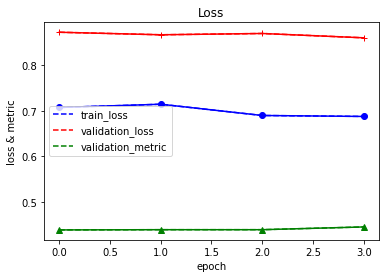

train loss =  [tensor(0.7070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.7142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.6896, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
val loss =  [0.8714851622581482, 0.8659525094032288, 0.8687757544517517, 0.8593240089416504]
val metric =  [0.4395, 0.44, 0.44, 0.446]


In [ ]:
p1 = plt.plot(range(epochs),train_losses,'b--',label='train_loss')
p2 = plt.plot(range(epochs),val_losses,'r--',label='validation_loss')
p3 = plt.plot(range(epochs),val_metrics,'g--',label='validation_metric')
plt.plot(range(epochs),train_losses,'bo-',range(epochs),val_losses,'r+-',range(epochs),val_metrics,'g^-')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss & metric')
plt.legend()
plt.show()
print('train loss = ', train_losses)
print('val loss = ', val_losses)
print('val metric = ', val_metrics)


In [ ]:
net = TextSimilarityModel(dropout_rate=dropout_rate, finetune_units=finetune_units,bert_model=bert_model)
net.load_state_dict(torch.load(MODEL_SAVE_PATH + path_to_model))
net.to(device)

test_set = LoadDataset(test, maxlen, with_labels=False, bert_model = bert_model)
test_loader = DataLoader(test_set, batch_size=bs)

net.eval()
results = []
with torch.no_grad():
    for token_ids1, attn_masks1, token_type_ids1, token_ids2, attn_masks2, token_type_ids2 in tqdm(test_loader):
        token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
        token_ids2, attn_masks2, token_type_ids2 =  token_ids2.to(device), attn_masks2.to(device), token_type_ids2.to(device)
#         ot1,ot2 = net(token_ids1, attn_masks1, token_type_ids1, token_ids2, attn_masks2, token_type_ids2)
#         cs=nn.CosineSimilarity()
#         output = cs(ot1,ot2)
        output = net(token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2)
        output = output.sigmoid().cpu().numpy()
        output = np.where(output>thres, 1, 0)
        results += output.tolist()

test['similarity'] = results

100%|██████████| 125/125 [00:13<00:00,  9.21it/s]


In [ ]:
test

,sentence_a,sentence_b,similarity
0,2005 年末至 2009 年期间是例外，当时他效力于瑞典的卡斯塔德联队、塞尔维亚的查查克足...,例外情况发生于 2005 年末至 2009 年期间，当时他效力于瑞典的卡斯塔德联队、塞尔维亚...,1
1,Tabaci 河是罗马尼亚 Leurda 河的支流。,Leurda 河是罗马尼亚境内 Tabaci 河的一条支流。,1
2,1993 年，他为 A 级的坎恩郡美洲狮队和 AA 级的波特兰海狗队效力。,1993 年，他为 A 级球队波特兰海狗队和 AA 级球队凯恩县美洲狮队效力。,1
3,Winarsky 是 IEEE、Phi Beta Kappa、ACM 和 Sigma Xi ...,温那斯基是 ACM、IEEE、Phi Beta Kappa 和 Sigma Xi 的成员。,1
4,1938 年，他成为英埃苏丹的政府人类学家，并领导对努巴的实地考察工作。,1938 年，他成为英埃苏丹政府的人类学家，并与努巴一起从事野外工作。,1
...,...,...,...
1995,《土地贝西之地》是贝西伯爵及其 1964 年管弦乐队的录音室专辑，该专辑的音乐由比利·拜尔斯...,《土地贝西之地》是比利·拜尔斯及其管弦乐队在 1964 年录制的录音室专辑，由贝西伯爵作曲和编曲。,1
1996,他们的任务是保护各种太空前哨不受敌舰群的攻击。,他们的使命是保护各个前哨免受敌人舰队的攻击。,1
1997,他的母亲伊丽莎白这边有康沃尔公国大法官威廉·莫当特爵士，以及民事诉讼法院首席书记约翰·莫当特。,他的母亲这边有康沃尔公国大法官伊丽莎白·威廉·莫当特爵士，以及民事诉讼法院首席书记约翰·莫当特。,1
1998,2014 年，该网站推出了用于搜索产品的 iOS 和 Android 应用程序；产品特色包括...,2014 年推出网站 iOS 和安卓应用程序，用于产品搜索，产品功能包括交互式视频 - 产品...,1
